# Adult Dataset Logistic Regression
Joseph Obonyo  
Source of Dataset: UCI Machine Learning Respository (https://archive.ics.uci.edu/ml/datasets/adult)  
The dataset was extracted by Barry Becker using data from the 1994 census. The goal of the task is to predict which adult earns over $50 thousand a year based on given data.

## Import Libraries And Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
import warnings
warnings.simplefilter(action='ignore', category=Warning)  # Used to ignore some a pandas warning about techniques used
# pd.set_option('max_columns', None)  # Allows all columns to be shown when displaying the dataset

In [2]:
DATA_FILE = 'adult.csv'

def load_data():
    csv_file = pd.read_csv(DATA_FILE, header=None)
    return csv_file

In [3]:
adult_df = load_data()
adult_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Clean The Data

The csv doesn't have proper headers. I will enter them manually using the dataset information on the UCI repository.  
Since the column names are up of the numbers from 0 - 14, a numpy array is all I need. The new column names go into a differnt array.

In [4]:
columns = np.arange(0, 15)
column_names = np.array(['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
                         'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 
                         'native_country', 'over_50k'])

This function uses a dictionary comprehension to create a dictionary that contains the old column names as the key, and the new column names as the value. The rename method replaces the key with the value.

In [5]:
def change_columns(df, old_columns, new_columns):
    new_column_names = {old_columns[i]: new_columns[i] for i in range(len(new_columns))}
    df_new_columns = df.rename(columns=new_column_names)
    return df_new_columns

In [6]:
adult_df = change_columns(df=adult_df, old_columns=columns, new_columns=column_names)
display(adult_df.info(), adult_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  over_50k        32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### Check For Missing Values

In [7]:
print('No. of missing values: \n', adult_df.isna().sum())

No. of missing values: 
 age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
over_50k          0
dtype: int64


Looks like there are no missing values, however, the dataset has '?' characters to represent missing values.

In [8]:
print('No. of special characters: \n', adult_df.isin([' ?']).sum())

No. of special characters: 
 age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
over_50k             0
dtype: int64


In [9]:
# Replaces the special character with nan and then drops the entries
adult_df['native_country'] = adult_df['native_country'].replace(' ?', np.nan)
adult_df['workclass'] = adult_df['workclass'].replace(' ?', np.nan)
adult_df['occupation'] = adult_df['occupation'].replace(' ?', np.nan)
#dropping the NaN rows now 
adult_df.dropna(how='any',inplace=True)

#### Encode target attribute
In order to easily create visualization using the 'over_50k' column, I'll need to encode <=50k and >50k as 0 and 1 respectively.  
The below function receives the dataframe and the target column name as parameters and applies a bin map through the use of a dictionary to encode the values, then returns the target column.

In [10]:
def encode_target(df, column_name):
    bin_map = {' <=50K': 0, ' >50K': 1}
    df[column_name] = df[column_name].map(bin_map)
    return df

In [11]:
adult_df = encode_target(df=adult_df, column_name='over_50k')

In [12]:
# Checking that encoding was done correctly
print("The values for the column 'over_50k' are {} for <=50k and {} for >50k".format(
    adult_df.over_50k.unique()[0],adult_df.over_50k.unique()[1]))

The values for the column 'over_50k' are 0 for <=50k and 1 for >50k


## Explore The Data Using Visualizations
This function receives the name of the png file to be saved as a parameter and saves it in the same folder as this python file.

In [13]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Numerical Data
This function receives the data and the title of the visualization to be saved as parameters and plots a histogram

In [14]:
def plot_hist(x, title):
    fig, ax = plt.subplots()
    sns.histplot(x=x, ax=ax)
    ax.set_title(title)
    save_fig(title)
    plt.show()

Saving figure Histogram Of Capital Gain


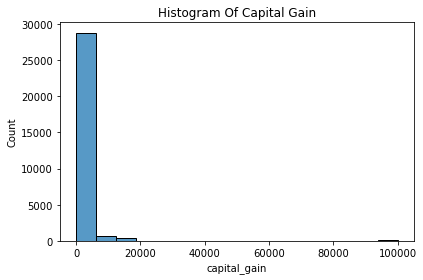

In [15]:
plot_hist(x=adult_df['capital_gain'], title='Histogram Of Capital Gain')

Saving figure Histogram Of Capital Loss


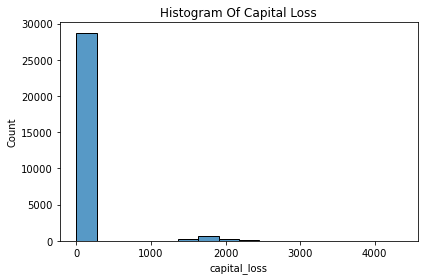

In [16]:
plot_hist(x=adult_df['capital_loss'], title='Histogram Of Capital Loss')

Saving figure KDE Plot of Age


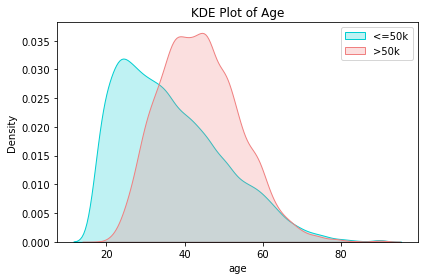

In [17]:
# Initialize the x variables
x = adult_df['age'][adult_df.over_50k == 0]
x1 = adult_df['age'][adult_df.over_50k == 1]

# Plot data
fig, ax = plt.subplots()
sns.kdeplot(x=x, color='darkturquoise', shade=True, ax=ax)
sns.kdeplot(x=x1, color='lightcoral', shade=True, ax=ax)
ax.legend(['<=50k', '>50k'])
ax.set_title('KDE Plot of Age')
save_fig('KDE Plot of Age')
plt.show()

Saving figure KDE Plot of Hours Per Week


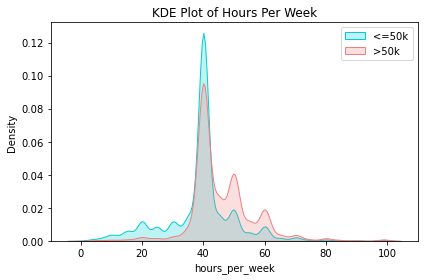

In [18]:
# Initialize the x variables
x = adult_df['hours_per_week'][adult_df.over_50k == 0]
x1 = adult_df['hours_per_week'][adult_df.over_50k == 1]

# Plot data
fig, ax = plt.subplots()
sns.kdeplot(x=x, color='darkturquoise', shade=True, ax=ax)
sns.kdeplot(x=x1, color='lightcoral', shade=True, ax=ax)
ax.legend(['<=50k', '>50k'])
ax.set_title('KDE Plot of Hours Per Week')
save_fig('KDE Plot of Hours Per Week')
plt.show()

#### Categorical Data
This function receives the data for the x and y axis, the degree of label rotation for the x axis lagels, as well as the title of the visualization to be saved, and plots a barchart. The y-axis shows the proportion of people earning over 50k for the given category.

In [19]:
def plot_bar(x, y, title, x_rotation):
    fig, ax = plt.subplots()
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_title(title)
    ax.tick_params(axis='x', labelrotation=x_rotation)
    save_fig(title)
    plt.show()

In [20]:
target = adult_df['over_50k']

Saving figure Bar Chart of Education Level


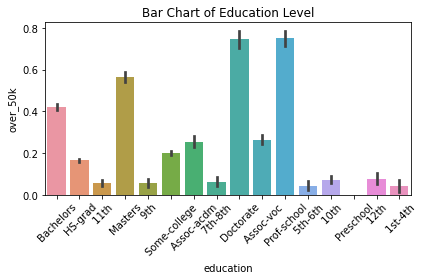

In [21]:
plot_bar(x=adult_df['education'], y=target, title='Bar Chart of Education Level', x_rotation=45)

Saving figure Bar Chart of Sex


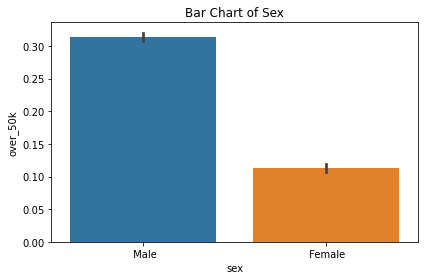

In [22]:
plot_bar(x=adult_df['sex'], y=target, title='Bar Chart of Sex', x_rotation=0)

Saving figure Bar Chart of Occupation


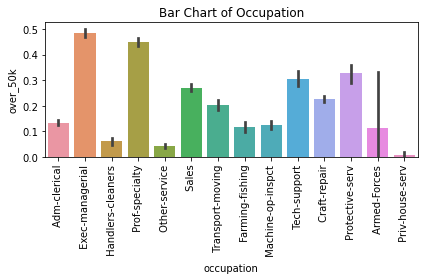

In [23]:
plot_bar(x=adult_df['occupation'], y=target, title='Bar Chart of Occupation', x_rotation=90)

## Preprocessing

#### Split Data Into Numerical and Categorical Attributes
The categorical attributes can't be fit to the machine learning algorithms without being encoded. I will split the dataframe in two and encode the dataframe with categorical attributes.

In [24]:
# Exclude all object attributes
num_columns_df = adult_df.select_dtypes(exclude=['object'])
# Dropping the 'over_50k' column because it was already encoded 
num_columns_df = num_columns_df.drop('over_50k', axis=1)
print('Numerical columns: ', num_columns_df.columns)

Numerical columns:  Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')


In [25]:
# Include only object attributes
object_columns_df = adult_df.select_dtypes(include=['object'])
print('Object columns: ', object_columns_df.columns)

Object columns:  Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country'],
      dtype='object')


I will use sci-kit learn's Ordinal Encoder to encode the categorical variables to make sure the data can be fitted to the machine learning algorithms.

In [26]:
from sklearn.preprocessing import OrdinalEncoder

In [27]:
# Fitting the object columns to the encoder
encoder = OrdinalEncoder()
encoded_objects = encoder.fit_transform(object_columns_df)

In [28]:
# Putting the column names back because the encoder returns a numpy array
encoded_objects = pd.DataFrame(encoded_objects, columns=object_columns_df.columns, dtype=int)
encoded_objects.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
0,5,9,4,0,1,4,1,38
1,4,9,2,3,0,4,1,38
2,2,11,0,5,1,4,1,38
3,2,1,2,5,0,2,1,38
4,2,9,2,9,5,2,0,4


In [29]:
# Concatenating the two dataframes on axis 1. It only includes predictors now.
encoded_objects.reset_index(drop=True, inplace=True)
num_columns_df.reset_index(drop=True, inplace=True)
encoded_df = pd.concat([encoded_objects, num_columns_df], axis=1, sort=False)
encoded_df.head(10)

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,5,9,4,0,1,4,1,38,39,77516,13,2174,0,40
1,4,9,2,3,0,4,1,38,50,83311,13,0,0,13
2,2,11,0,5,1,4,1,38,38,215646,9,0,0,40
3,2,1,2,5,0,2,1,38,53,234721,7,0,0,40
4,2,9,2,9,5,2,0,4,28,338409,13,0,0,40
5,2,12,2,3,5,4,0,38,37,284582,14,0,0,40
6,2,6,3,7,1,2,0,22,49,160187,5,0,0,16
7,4,11,2,3,0,4,1,38,52,209642,9,0,0,45
8,2,12,4,9,1,4,0,38,31,45781,14,14084,0,50
9,2,9,2,3,0,4,1,38,42,159449,13,5178,0,40


In [30]:
# Assigning the predictors and the target to X and y variables
X = encoded_df
y = target

#### View correlation of selected features

Saving figure Correlation Heatmap


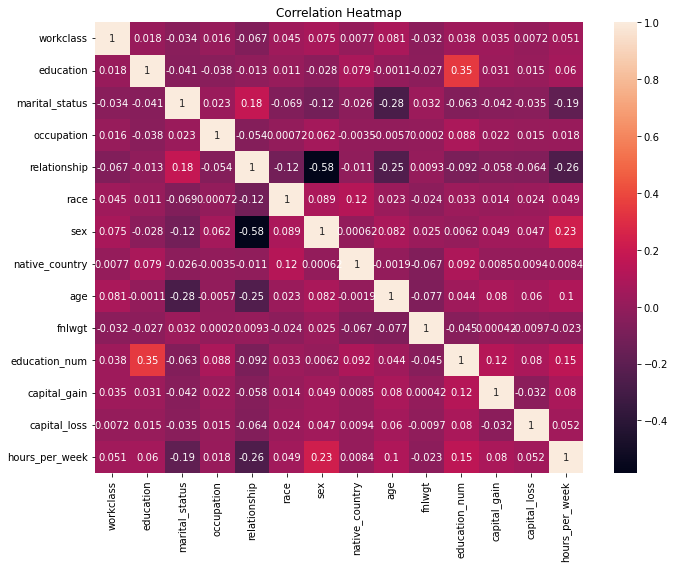

In [31]:
def plot_corr(x, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(x.corr(), annot=True, ax=ax)
    ax.set_title(title)
    save_fig(title)
    plt.show()
    
plot_corr(x=X, title='Correlation Heatmap')

## Build and Evaluate Model
Train test split is the best indicator of how the model will perform on out-of-sample data, however, the accuracy will vary due to which entries happen to be in the testing set. Testing with different random states helps to see the extent of this variance in accuracy.

#### Logistic Regression

Train/Test split results:


,precision,recall,f1-score,support
<=50k,0.789896,0.945126,0.860567,4483.000000
>50k,0.632287,0.272903,0.381253,1550.000000
accuracy,0.772418,0.772418,0.772418,0.772418
macro avg,0.711091,0.609015,0.620910,6033.000000
weighted avg,0.749403,0.772418,0.737421,6033.000000


Saving figure ROC Curve Log Reg


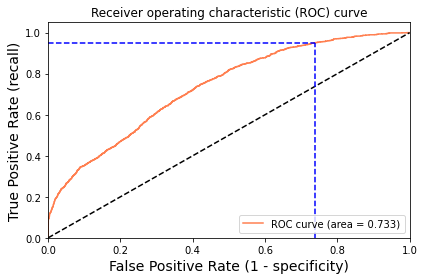

In [32]:
def build_model_log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # check classification scores of logistic regression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
    print('Train/Test split results:')
    # Define the target names
    target_names = ['<=50k', '>50k']

    # Build a classifcation report
    report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

    # Add it to a data frame, transpose it for readability.
    report_df = pd.DataFrame(report).transpose()
    display(report_df)

    idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensitivity > 0.95

    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    save_fig('ROC Curve Log Reg')
    plt.show()
    
build_model_log_reg(X, y)          

#### Random Forest Classifier

Train/Test split results:


,precision,recall,f1-score,support
<=50k,0.877120,0.934642,0.904968,4483.000000
>50k,0.766720,0.621290,0.686386,1550.000000
accuracy,0.854136,0.854136,0.854136,0.854136
macro avg,0.821920,0.777966,0.795677,6033.000000
weighted avg,0.848756,0.854136,0.848810,6033.000000


Saving figure ROC Curve Rand Frst


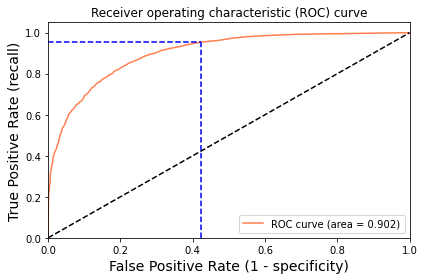

In [33]:
def build_model_rand_frst(X, y):
    # Split X and y into X_
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

    # Create a Random Forest Classifier
    rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

    # Fit the data to the model
    rand_frst_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    y_pred_proba = rand_frst_clf.predict_proba(X_test)[:, 1]
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
    
    # Display accuracy results
    print('Train/Test split results:')
    # Define the target names
    target_names = ['<=50k', '>50k']

    # Build a classifcation report
    report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

    # Add it to a data frame, transpose it for readability.
    report_df = pd.DataFrame(report).transpose()
    display(report_df)
    idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensitivity > 0.95
    
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    save_fig('ROC Curve Rand Frst')
    plt.show()
    
    
    
build_model_rand_frst(X, y)

## Improving the models

#### Feature selection
I will use RFE (Recursive Feature Selection) to reduce the number of attributes we fit into the algorithm, and check if that improves the results. The focus will be on random forest classifier since the results were significantly better.

In [34]:
# First I will try reducing the features down to 10 and check which ones were removed
def select_features_n(X, y, n_features):
    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=n_features)
    rfe = rfe.fit(X, y)
    selected_features = np.array(X.columns[rfe.support_])
    print('Selected features: %s' % selected_features)
    total_features = np.array(X.columns)
    print('Features removed: %s' % np.setdiff1d(total_features, selected_features) )
    
select_features_n(X=X, y=y, n_features=10)

Selected features: ['workclass' 'marital_status' 'occupation' 'relationship' 'age' 'fnlwgt'
 'education_num' 'capital_gain' 'capital_loss' 'hours_per_week']
Features removed: ['education' 'native_country' 'race' 'sex']


Optimal number of features: 10
Selected features: ['workclass', 'marital_status', 'occupation', 'relationship', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Saving figure Cross Validation Scores


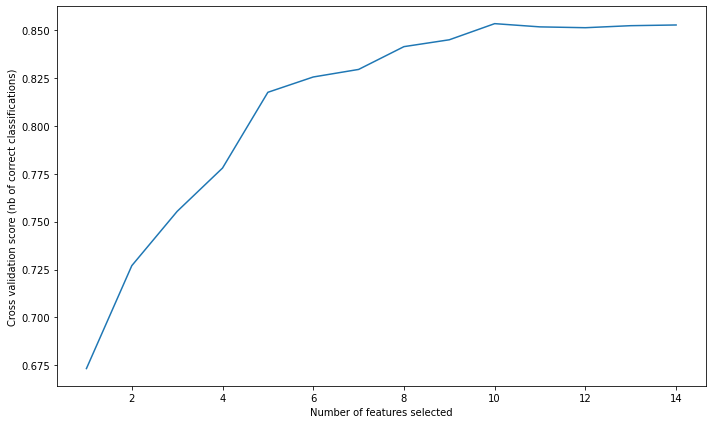

In [34]:
# Now trying to see which features are selected when cross validation is used to eliminate them one by one.
# The set with the highest cross validation is selected
def select_features_cv(X, y):
    # Create the RFE object and compute a cross-validated score.
    # The "accuracy" scoring is proportional to the number of correct classifications
    rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=10, scoring='accuracy')
    rfecv.fit(X, y)

    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % list(X.columns[rfecv.support_]))

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    save_fig(fig_id='Cross Validation Scores')
    plt.show()

select_features_cv(X, y)

In [35]:
# Create a list of the selected features from the algorithm
selected_features = ['workclass', 'marital_status', 'occupation', 'relationship', 'age', 'fnlwgt', 'education_num',
                     'capital_gain', 'capital_loss', 'hours_per_week']
X = encoded_df[selected_features]

#### Logisitic Regression

#### Random Forest Classifier

Train/Test split results:


,precision,recall,f1-score,support
<=50k,0.876658,0.929065,0.902101,4483.000000
>50k,0.751950,0.621935,0.680791,1550.000000
accuracy,0.850157,0.850157,0.850157,0.850157
macro avg,0.814304,0.775500,0.791446,6033.000000
weighted avg,0.844618,0.850157,0.845242,6033.000000


Saving figure ROC Curve Rand Frst


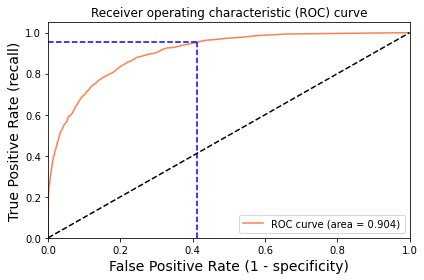

In [36]:
def build_model_rand_frst(X, y):
    # Split X and y into X_
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

    # Create a Random Forest Classifier
    rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

    # Fit the data to the model
    rand_frst_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    y_pred_proba = rand_frst_clf.predict_proba(X_test)[:, 1]
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
    
    # Display accuracy results
    print('Train/Test split results:')
    # Define the target names
    target_names = ['<=50k', '>50k']

    # Build a classifcation report
    report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

    # Add it to a data frame, transpose it for readability.
    report_df = pd.DataFrame(report).transpose()
    display(report_df)
    idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensitivity > 0.95
    
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    save_fig('ROC Curve Rand Frst')
    plt.show()
    
build_model_rand_frst(X, y)

#### Conclusions
- The results remained almost exactly the same after feature selection. There were no features that added unnecessary noise to the Random Forest Classifier.